In [1]:
import glob
import os
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import math
%matplotlib inline

In [4]:
old_image_folder='ori_organized'
new_image_folder='bw'
file_type='png'

In [7]:
curdir = os.path.dirname(os.getcwd())
directory = '{}/input/{}_{}'.format(curdir,
                                            new_image_folder,
                                            old_image_folder)
if not os.path.exists(directory):
    os.makedirs(directory)

filelist = glob.glob('{}/input/{}/*.{}'.format(curdir,
                                               old_image_folder,
                                               '*'))

In [8]:
filelist

['/Users/Walkon302/Desktop/MEMA_organization/input/ori_organized/PC3_M_DMSO_pHER2.jpg',
 '/Users/Walkon302/Desktop/MEMA_organization/input/ori_organized/PC3_M_Lap_ALL.jpg']

In [41]:
class ImagePreprocess(object):

    @staticmethod
    def image_bw(old_image_folder='ori_organized',
                 new_image_folder='bw',
                 file_type='png'):

        """
        Load old RGB image and convert it to black and white.
        """

        curdir = os.path.dirname(os.getcwd())

        directory = '{}/input/{}_{}'.format(curdir,
                                            new_image_folder,
                                            old_image_folder)
        if not os.path.exists(directory):
            os.makedirs(directory)

        filelist = glob.glob('{}/input/{}/*.{}'.format(curdir,
                                                       old_image_folder,
                                                       file_type))

        for file_name in filelist:
            im = Image.open(file_name)
            im_bw = im.convert('1')
            im_bw.save('{}/bw_{}'.format(directory,
                                         os.path.basename(file_name)),
                                         file_type)

    @staticmethod
    def image_resize(old_image_folder='bw_ori_organized',
                     new_image_folder='resize',
                     canvas_size=300,
                     file_type='png'):

        """
        Place one image on another image.

        Resize the canvas of old_image_path and store the new image in
        new_image_path. Center the image on the new canvas.
        """

        curdir = os.path.dirname(os.getcwd())

        directory = '{}/input/{}_{}'.format(curdir,
                                            new_image_folder,
                                            old_image_folder)
        if not os.path.exists(directory):
            os.makedirs(directory)

        filelist = glob.glob('{}/input/{}/*.{}'.format(curdir,
                                                       old_image_folder,
                                                       file_type))

        for file_name in filelist:
            im = Image.open(file_name)
            canvas_size = max(canvas_size, im.size[0], im.size[1])

        for file_name in filelist:
            im = Image.open(file_name)
            old_width, old_height = im.size

            # Center the image
            x1 = int(math.floor((canvas_size - old_width) / 2))
            y1 = int(math.floor((canvas_size - old_height) / 2))

            mode = im.mode
            if len(mode) == 1:  # L, 1
                new_background = (0)
            if len(mode) == 3:  # RGB
                new_background = (0, 0, 0)
            if len(mode) == 4:  # RGBA, CMYK
                new_background = (0, 0, 0, 0)

            new_image = Image.new(mode,
                                  (canvas_size, canvas_size),
                                  new_background)
            new_image.paste(im, (x1, y1, x1 + old_width, y1 + old_height))
            new_image.save('{}/resize_{}'.format(directory,
                                                 os.path.basename(file_name)),
                                                 file_type)

In [20]:
class ImageAugementation(object):

    @staticmethod
    def image_to_array(image_file_list):
        return np.array([cv2.imread(file_name, 0)
                        for file_name in image_file_list])

    @staticmethod
    def image_rotation(image_array, degree=90):
        result = []
        rows, cols = image_array[0].shape
        for image in image_array:
            r_m = cv2.getRotationMatrix2D((cols/2, rows/2),
                                          degree ,1)
            image_modified = cv2.warpAffine(image, r_m,
                                            (cols, rows))
            result.append(image_modified)
        return np.array(result)

    @staticmethod
    def image_flip(image_array):
        result = []
        for image in image_array:
            x_flip = cv2.flip(image, 0)
            y_flip = cv2.flip(image, 1)
            result.append(x_flip)
            result.append(y_flip)
        return np.array(result)

    @staticmethod
    def image_resize(image_array):
        result = []
        dim = (128, 128)
        for image in image_array:
            resized = cv2.resize(image, dim,
                                 interpolation=cv2.INTER_AREA)
            result.append(resized)
        return np.array(result)

    @staticmethod
    def image_augmentation(image_array):
        flip = ImageAugementation.image_flip(image_array)
        rotation = ImageAugementation.image_rotation(image_array)
        return np.concatenate([image_array, flip, rotation])

In [56]:
class DataPreProcess(object):

    @staticmethod
    def data_prepared(folder):

        cur_path = '{}/input'.format(os.path.dirname(os.getcwd()))

        work_path = '{}/{}'.format(cur_path, folder)

        file_list = glob.glob('{}/*'.format(work_path))
        
        image_array = ImageAugementation.image_to_array(file_list)
        
        image_array_aug = ImageAugementation.image_augmentation(image_array)

        image_array_aug_resize = ImageAugementation.image_resize(image_array_aug)

        return image_array_aug_resize

    @staticmethod
    def preprocess(np_array):
        np_array = np.array(np_array/255., dtype = 'float32')
        np_array = np_array.reshape([len(np_array),
                                    np_array.shape[1]*np_array.shape[2]])
        return np_array

    @staticmethod
    def data_generate(pos, neg, n):
        final = min(len(pos), len(neg))
        train_sample = np.concatenate([pos[0:n], neg[0:n]])
        eval_sample = np.concatenate([pos[n:final], neg[n:final]])
        train_label = np.concatenate([np.repeat(0, n), np.repeat(1, n)])
        eval_label = np.concatenate(
        [np.repeat(0, final-n), np.repeat(1, final-n)]
        )

        train_sample, train_label = shuffle(train_sample,
                                            train_label,
                                            random_state=0)
        eval_sample, eval_label = shuffle(eval_sample,
                                          eval_label,
                                          random_state=0)

        return train_sample, train_label, eval_sample, eval_label
    
    @staticmethod
    def predict_prep(folder='predict'):
        
        ImagePreprocess.image_bw(old_image_folder=folder)
        ImagePreprocess.image_resize(old_image_folder='bw_predict')
        
        cur_path = '{}/input'.format(os.path.dirname(os.getcwd()))
        work_path = '{}/{}'.format(cur_path, 'resize_bw_predict')
        file_list = glob.glob('{}/*'.format(work_path))
        image_array = ImageAugementation.image_to_array(file_list)
        image_array_resize = ImageAugementation.image_resize(image_array)

        file_name = []
        for f in file_list:
            file_name.append(os.path.basename(f))
        file_name = np.array(file_name)
        return image_array_resize, file_name

In [57]:
pred_array, pred_file = DataPreProcess.predict_prep('predict')

In [61]:
pred_array

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [44]:
ImagePreprocess.image_bw(old_image_folder='predict')
ImagePreprocess.image_resize(old_image_folder='bw_predict')

In [54]:
cur_path = '{}/input'.format(os.path.dirname(os.getcwd()))
work_path = '{}/{}'.format(cur_path, 'resize_bw_predict')
file_list = glob.glob('{}/*'.format(work_path))
image_array = ImageAugementation.image_to_array(file_list)
image_array_resize = ImageAugementation.image_resize(image_array)


file_name = []
for f in file_list:
    file_name.append(os.path.basename(f))
file_name = np.array(file_name)

np.save('pred_array', image_array_resize)
np.save('pred_file', file_name)

In [29]:
good_list = glob.glob('/Users/Walkon302/Desktop/MEMA_data/organized/*')
bad_list = glob.glob('/Users/Walkon302/Desktop/MEMA_data/disorganized/*')
good_array = ImageAugementation.image_to_array(good_list)
bad_array = ImageAugementation.image_to_array(bad_list)
good = ImageAugementation.image_augmentation(good_array)
bad = ImageAugementation.image_augmentation(bad_array)
good_re = ImageAugementation.image_resize(good)
bad_re = ImageAugementation.image_resize(bad)

In [44]:
np.save('good_re', good_re)
np.save('bad_re', bad_re)

In [26]:
good_re = ImageAugementation.image_resize(good)

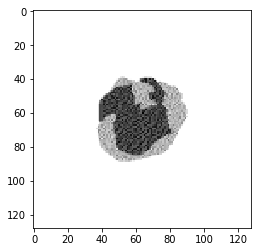

In [28]:
plt.imshow(good_re[0], cmap='Greys')

In [51]:
dim = (32, 32)
 
# perform the actual resizing of the image and show it
resized = cv2.resize(a[0], dim, interpolation = cv2.INTER_AREA)

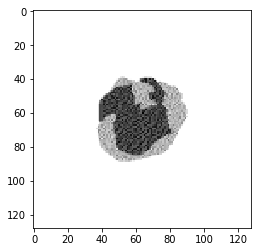

In [52]:
plt.imshow(a[0], cmap='Greys')

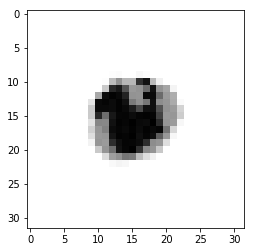

In [53]:
plt.imshow(resized, cmap='Greys')

In [43]:
os.path.dirname(os.getcwd())

'/Users/Walkon302/Desktop'